In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [140]:
full_df = pd.read_csv('rosbank_train.csv')
full_df.head(5)

full_test = pd.read_csv('rosbank_test.csv')
full_test.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS


In [141]:
#Посмотрим, какие наборы данный у нас есть. На сколько много пропущенных элементов
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [142]:
full_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518376 entries, 0 to 518375
Data columns (total 8 columns):
PERIOD          518376 non-null object
cl_id           518376 non-null int64
MCC             518376 non-null int64
channel_type    516222 non-null object
currency        518376 non-null int64
TRDATETIME      518376 non-null object
amount          518376 non-null float64
trx_category    518376 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 31.6+ MB


In [143]:
print("Total clients: ", len(full_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [144]:
print("Total clients: ", len(full_test.cl_id.unique()))

Total clients:  5217


In [145]:
cl_ids_test = np.random.choice(full_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [146]:
# create transactions dataset for train
train = full_df[~full_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(train))
# create transactions dataset for test
test = full_df[full_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(test))

Total transactions in train dataset:  394254
Total transactions in test dataset:  96259


In [147]:
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [148]:
#Посмотрим сколько операций каждого типа есть в нашем датасете
train.groupby('trx_category').size()

trx_category
BACK_TRX            2237
C2C_IN              5989
C2C_OUT             4334
CASH_ADV              33
CAT                  971
DEPOSIT            17306
POS               334506
WD_ATM_OTHER        5893
WD_ATM_PARTNER      7841
WD_ATM_ROS         15144
dtype: int64

In [149]:
#Посмотрим, сколько каналов используется
train['channel_type'].value_counts()

type1    241598
type2    139925
type5      4385
type4      3372
type3      2336
Name: channel_type, dtype: int64

In [150]:
#Посмотрим, как распределены транзакции по периодам
train['PERIOD'].value_counts()

01/07/2017    45238
01/06/2017    43258
01/08/2017    37877
01/12/2016    37208
01/05/2017    37197
01/01/2017    35550
01/04/2017    34323
01/02/2017    29389
01/03/2017    28071
01/09/2017    23096
01/11/2016    17073
01/10/2017     9284
01/11/2017     3987
01/12/2017     3788
01/10/2016     2861
01/01/2018     2424
01/02/2018     1893
01/03/2018     1709
01/04/2018       28
Name: PERIOD, dtype: int64

### Генерация фичей

Начнем генерировать наши фичи. Поскольку изначально у нас есть таблица с транзакциями, а нам необходимо перейти в таблицу с пользователями, общий подход будет в группировке данных по пользователям и потом соединением таких небольших табличек в одну

In [151]:
#Для начал сгруппируем по количеству МСС на пользователя. Отбираем уникальные МСС для пользователя
tr=train.groupby(['cl_id', 'MCC']).agg({'MCC': np.unique})
tr_test=test.groupby(['cl_id', 'MCC']).agg({'MCC': np.unique})

In [152]:
#Проделаем все те же самые манипуляции для полных выборок
mcc=full_df.groupby(['cl_id', 'MCC']).agg({'MCC': np.unique})
mcc_test=full_test.groupby(['cl_id', 'MCC']).agg({'MCC': np.unique})

In [153]:
#Считаем количество различных МСС для каждого пользователя
r=tr.groupby('cl_id').agg({'MCC': np.size})
r.reset_index(inplace=True)
r.head()

r_test=tr_test.groupby('cl_id').agg({'MCC': np.size})
r_test.reset_index(inplace=True)
r_test.head()

,cl_id,MCC
0,14,30
1,21,35
2,38,5
3,50,15
4,55,28


In [154]:
mcc=mcc.groupby('cl_id').agg({'MCC': np.size})
mcc.reset_index(inplace=True)

mcc_test=mcc_test.groupby('cl_id').agg({'MCC': np.size})
mcc_test.reset_index(inplace=True)

In [155]:
#Второе действие, посчитаем общую сумму всех транзакций пользователя
am=train.groupby(['cl_id']).agg({'amount': np.sum})
am_test=test.groupby(['cl_id']).agg({'amount': np.sum})

In [156]:
am_full=full_df.groupby(['cl_id']).agg({'amount': np.sum})
am_full_test=full_test.groupby(['cl_id']).agg({'amount': np.sum})

In [157]:
am.reset_index(inplace=True)
am.head()

am_test.reset_index(inplace=True)
am_test.head()

,cl_id,amount
0,14,448690.17
1,21,338881.65
2,38,296808.00
3,50,267108.91
4,55,352452.82


In [158]:
am_full.reset_index(inplace=True)

am_full_test.reset_index(inplace=True)

In [159]:
#Проводим первую "склейку" фичей. Соединяем количество различных МСС с общей суммой транзакций при помощи merge
r=r.merge( am, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r_test=r_test.merge( am_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )

In [160]:
r_test.head()

,cl_id,MCC,amount
0,14,30,448690.17
1,21,35,338881.65
2,38,5,296808.00
3,50,15,267108.91
4,55,28,352452.82


In [161]:
mcc=mcc.merge( am_full, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test=mcc_test.merge( am_full_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )

In [162]:
mcc.head()

,cl_id,MCC,amount
0,0,5,64383.00
1,1,23,267578.04
2,5,34,546369.13
3,9,5,849315.09
4,10,36,1124343.99


In [163]:
#Выделим целевую переменную
Y=train.groupby(['cl_id']).agg({'target_flag': np.mean})
Y_test=test.groupby(['cl_id']).agg({'target_flag': np.mean})

In [164]:
Y['target_flag'].value_counts()

1    2204
0    1796
Name: target_flag, dtype: int64

In [165]:
Y_full=full_df.groupby(['cl_id']).agg({'target_flag': np.mean})

In [166]:
#Создадим сводную таблицу на осих Х- отложим категории операций, на оси Y- клиентов
#а в качестве значений возьмем сумму по данной категории операций
trx_sum = train.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)

trx_sum.head()

trx_sum_test = test.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)

trx_sum_test.head()

trx_category,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
cl_id,,,,,,,,,,
14,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,0.0,0.0,37000.0
21,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,0.0,0.0,10000.0
50,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,0.0,0.0,0.0


In [167]:
#Посмотрим, как распределены транзакции по периодам
periods=train['PERIOD'].unique()

In [168]:
mask = ( train.PERIOD == '01/10/2017' )
train.loc[mask].head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.0,POS,0,0.0
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.0,POS,0,0.0
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.0,POS,0,0.0
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.0,POS,0,0.0
12,01/10/2017,1,5812,NaN,978,01OCT17:00:00:00,21.0,POS,0,0.0
14,01/10/2017,1,5814,NaN,810,08OCT17:00:00:00,5988.8,POS,0,0.0


In [169]:
trx_full_sum = full_df.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)

trx_full_sum_test = full_test.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)

trx_full_sum_test.head()

trx_category,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
cl_id,,,,,,,,,,
2,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,0.0,78500.0,55400.0
3,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,9800.0,0.0,34900.0
4,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,0.0,30500.0,21300.0
6,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,2500.0,42200.0,95600.0
7,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,23200.0,46600.0,14900.0


In [170]:
trx_sum.reset_index(inplace=True)
trx_sum_test.reset_index(inplace=True)

In [171]:
trx_full_sum.reset_index(inplace=True)
trx_full_sum_test.reset_index(inplace=True)

In [172]:
trx_sum.head()

trx_category,cl_id,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
0,0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [173]:
#Во избежании путанницы с колонками переименуем получившиеся колонки, для этого к названию каждой из них добави постфикс "_am"

coln=trx_sum.columns
col2=[]
col2.append('cl_id')
for c in coln:
    if c!='cl_id':
        c2=c+'_am'
        col2.append(c2)
trx_sum.columns=col2

In [174]:
trx_sum_test.columns=col2
trx_full_sum.columns=col2
trx_full_sum_test.columns=col2

In [175]:
trx_sum.head()

,cl_id,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,WD_ATM_OTHER_am,WD_ATM_PARTNER_am,WD_ATM_ROS_am
0,0,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [176]:
#ДОбавим новые колонки на набору фичей
r=r.merge( trx_sum, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r.head()

r_test=r_test.merge( trx_sum_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,WD_ATM_OTHER_am,WD_ATM_PARTNER_am,WD_ATM_ROS_am
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,0.0,0.0,37000.0
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,0.0,0.0,0.0
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,0.0,0.0,10000.0
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,0.0,0.0,0.0
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,0.0,0.0,0.0


In [177]:
r.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,WD_ATM_OTHER_am,WD_ATM_PARTNER_am,WD_ATM_ROS_am
0,0,5,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,0.0,0.0,0.0
1,1,23,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,0.0,0.0,50000.0
2,5,34,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,5500.0,6000.0,66500.0
3,9,5,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,0.0,100000.0,435000.0
4,10,36,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,0.0,5400.0,422300.0


In [178]:
mcc=mcc.merge( trx_full_sum, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test=mcc_test.merge( trx_full_sum_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )

In [179]:
mcc_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,WD_ATM_OTHER_am,WD_ATM_PARTNER_am,WD_ATM_ROS_am
0,2,29,328717.72,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,0.0,78500.0,55400.0
1,3,22,270848.77,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,9800.0,0.0,34900.0
2,4,33,338177.98,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,0.0,30500.0,21300.0
3,6,32,460876.84,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,2500.0,42200.0,95600.0
4,7,25,194243.43,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,23200.0,46600.0,14900.0


In [180]:
#Посмотрим, как распределены транзакции по периодам
periods=train['PERIOD'].unique()
#Разобьем все транзакции по периодам в которые они были сделаны. Для каждого периода сделаем сводную таблицу
#По оси X отложим категории за период, по оси Y идентификаторы клиентов
for period in periods:
    mask = ( train.PERIOD == period )
    trx = train.loc[mask]
    trx_pr_sum = trx.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)
    trx_pr_sum.reset_index(inplace=True)
    #Для каждого периода сделаем переименование столбцов
    coln=trx_pr_sum.columns
    col2=[]
    col2.append('cl_id')
    for c in coln:
        if c!='cl_id':
            c2=c+ '_' +period
            col2.append(c2)
    trx_pr_sum.columns=col2
    r=r.merge( trx_pr_sum, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )
    #для пользователей, для которых нет значений по данному виду транзакции с период, добавляем нули
    for co in col2:
        r[co].fillna( 0, inplace = True )
        
r.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_ROS_01/04/2018,BACK_TRX_01/10/2016,C2C_IN_01/10/2016,C2C_OUT_01/10/2016,CAT_01/10/2016,DEPOSIT_01/10/2016,POS_01/10/2016,WD_ATM_OTHER_01/10/2016,WD_ATM_PARTNER_01/10/2016,WD_ATM_ROS_01/10/2016
0,0,5,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,23,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,34,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,5,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,36,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [181]:
#Посмотрим, как распределены транзакции по периодам
periods=test['PERIOD'].unique()
#Разобьем все транзакции по периодам в которые они были сделаны. Для каждого периода сделаем сводную таблицу
#По оси X отложим категории за период, по оси Y идентификаторы клиентов
for period in periods:
    mask = ( test.PERIOD == period )
    trx = test.loc[mask]
    trx_pr_sum = trx.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)
    trx_pr_sum.reset_index(inplace=True)
    #Для каждого периода сделаем переименование столбцов
    coln=trx_pr_sum.columns
    col2=[]
    col2.append('cl_id')
    for c in coln:
        if c!='cl_id':
            c2=c+ '_' +period
            col2.append(c2)
    trx_pr_sum.columns=col2
    r_test=r_test.merge( trx_pr_sum, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )
    #для пользователей, для которых нет значений по данному виду транзакции с период, добавляем нули
    for co in col2:
        r_test[co].fillna( 0, inplace = True )
        
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,C2C_OUT_01/10/2016,CAT_01/10/2016,DEPOSIT_01/10/2016,POS_01/10/2016,WD_ATM_OTHER_01/10/2016,WD_ATM_PARTNER_01/10/2016,WD_ATM_ROS_01/10/2016,C2C_IN_01/04/2018,POS_01/04/2018,WD_ATM_ROS_01/04/2018
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
#Оставляем только общие колонки для train и test
r_col =r.columns
r_test_col=r_test.columns
cols=r_col&r_test_col
cols

Index(['cl_id', 'MCC', 'amount', 'BACK_TRX_am', 'C2C_IN_am', 'C2C_OUT_am',
       'CASH_ADV_am', 'CAT_am', 'DEPOSIT_am', 'POS_am',
       ...
       'WD_ATM_ROS_01/04/2018', 'BACK_TRX_01/10/2016', 'C2C_IN_01/10/2016',
       'C2C_OUT_01/10/2016', 'CAT_01/10/2016', 'DEPOSIT_01/10/2016',
       'POS_01/10/2016', 'WD_ATM_OTHER_01/10/2016',
       'WD_ATM_PARTNER_01/10/2016', 'WD_ATM_ROS_01/10/2016'],
      dtype='object', length=176)

In [183]:
r = r[cols]
r_test=r_test[cols]

In [184]:
#Посмотрим, как распределены транзакции по периодам
periods=full_df['PERIOD'].unique()
#Разобьем все транзакции по периодам в которые они были сделаны. Для каждого периода сделаем сводную таблицу
#По оси X отложим категории за период, по оси Y идентификаторы клиентов
for period in periods:
    mask = ( full_df.PERIOD == period )
    trx = full_df.loc[mask]
    trx_pr_sum = trx.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)
    trx_pr_sum.reset_index(inplace=True)
    #Для каждого периода сделаем переименование столбцов
    coln=trx_pr_sum.columns
    col2=[]
    col2.append('cl_id')
    for c in coln:
        if c!='cl_id':
            c2=c+ '_' +period
            col2.append(c2)
    trx_pr_sum.columns=col2
    mcc=mcc.merge( trx_pr_sum, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )
    #для пользователей, для которых нет значений по данному виду транзакции с период, добавляем нули
    for co in col2:
        mcc[co].fillna( 0, inplace = True )
        
mcc.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_ROS_01/04/2018,BACK_TRX_01/10/2016,C2C_IN_01/10/2016,C2C_OUT_01/10/2016,CAT_01/10/2016,DEPOSIT_01/10/2016,POS_01/10/2016,WD_ATM_OTHER_01/10/2016,WD_ATM_PARTNER_01/10/2016,WD_ATM_ROS_01/10/2016
0,0,5,64383.00,0.0,0.0,36562.00,0.0,0.00,20000.0,7821.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,23,267578.04,0.0,0.0,0.00,0.0,0.00,95000.0,122578.04,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,34,546369.13,13990.0,0.0,33878.38,0.0,0.00,130000.0,290500.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,5,849315.09,0.0,296950.0,0.00,0.0,0.00,5000.0,12365.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,36,1124343.99,0.0,10000.0,21692.90,0.0,37694.98,426300.0,200956.11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
#Посмотрим, как распределены транзакции по периодам
periods=full_test['PERIOD'].unique()
#Разобьем все транзакции по периодам в которые они были сделаны. Для каждого периода сделаем сводную таблицу
#По оси X отложим категории за период, по оси Y идентификаторы клиентов
for period in periods:
    mask = ( full_test.PERIOD == period )
    trx = full_df.loc[mask]
    trx_pr_sum = trx.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc=sum).fillna(0).applymap(float)
    trx_pr_sum.reset_index(inplace=True)
    #Для каждого периода сделаем переименование столбцов
    coln=trx_pr_sum.columns
    col2=[]
    col2.append('cl_id')
    for c in coln:
        if c!='cl_id':
            c2=c+ '_' +period
            col2.append(c2)
    trx_pr_sum.columns=col2
    mcc_test=mcc_test.merge( trx_pr_sum, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )
    #для пользователей, для которых нет значений по данному виду транзакции с период, добавляем нули
    for co in col2:
        mcc_test[co].fillna( 0, inplace = True )
        
mcc_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_ROS_01/10/2016,BACK_TRX_01/12/2017,C2C_IN_01/12/2017,C2C_OUT_01/12/2017,CAT_01/12/2017,DEPOSIT_01/12/2017,POS_01/12/2017,WD_ATM_OTHER_01/12/2017,WD_ATM_PARTNER_01/12/2017,WD_ATM_ROS_01/12/2017
0,2,29,328717.72,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,22,270848.77,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,33,338177.98,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,32,460876.84,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,25,194243.43,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
#Оставляем только общие колонки для train и test
mcc_col =mcc.columns
mcc_test_col=mcc_test.columns
cols=mcc_col&mcc_test_col
cols

Index(['cl_id', 'MCC', 'amount', 'BACK_TRX_am', 'C2C_IN_am', 'C2C_OUT_am',
       'CASH_ADV_am', 'CAT_am', 'DEPOSIT_am', 'POS_am',
       ...
       'WD_ATM_ROS_01/04/2018', 'BACK_TRX_01/10/2016', 'C2C_IN_01/10/2016',
       'C2C_OUT_01/10/2016', 'CAT_01/10/2016', 'DEPOSIT_01/10/2016',
       'POS_01/10/2016', 'WD_ATM_OTHER_01/10/2016',
       'WD_ATM_PARTNER_01/10/2016', 'WD_ATM_ROS_01/10/2016'],
      dtype='object', length=188)

In [187]:
mcc = mcc[cols]
mcc_test=mcc_test[cols]

In [188]:
#Создадим сводную таблицу на осих Х- отложим категории операций, на оси Y- клиентов
#а в качестве значений возьмем количество операций по данной категории
trx_con = train.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc='count').fillna(0).applymap(float)

trx_con.head()

trx_con_test = test.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc='count').fillna(0).applymap(float)

trx_con_test.head()

trx_category,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
cl_id,,,,,,,,,,
14,0.0,3.0,0.0,0.0,0.0,0.0,132.0,0.0,0.0,1.0
21,1.0,2.0,0.0,0.0,0.0,8.0,113.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,2.0,9.0,0.0,0.0,1.0
50,0.0,5.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0
55,0.0,0.0,0.0,0.0,0.0,1.0,119.0,0.0,0.0,0.0


In [189]:
trx_full_con = full_df.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc='count').fillna(0).applymap(float)

trx_full_con_test = full_test.pivot_table(
                        index='cl_id', 
                        columns='trx_category', 
                        values='amount', 
                        aggfunc='count').fillna(0).applymap(float)

trx_full_con_test.head()

trx_category,BACK_TRX,C2C_IN,C2C_OUT,CASH_ADV,CAT,DEPOSIT,POS,WD_ATM_OTHER,WD_ATM_PARTNER,WD_ATM_ROS
cl_id,,,,,,,,,,
2,2.0,1.0,1.0,0.0,0.0,0.0,175.0,0.0,11.0,9.0
3,0.0,2.0,2.0,0.0,0.0,0.0,78.0,4.0,0.0,10.0
4,0.0,0.0,2.0,0.0,0.0,0.0,146.0,0.0,6.0,4.0
6,0.0,2.0,6.0,0.0,7.0,1.0,206.0,1.0,6.0,20.0
7,1.0,0.0,1.0,0.0,0.0,1.0,141.0,13.0,4.0,11.0


In [190]:
trx_con.reset_index(inplace=True)
trx_con_test.reset_index(inplace=True)

In [191]:
trx_full_con.reset_index(inplace=True)
trx_full_con_test.reset_index(inplace=True)

In [192]:
#Во избежании путанницы с колонками переименуем получившиеся колонки, для этого к названию каждой из них добави постфикс "_con"

coln=trx_con.columns
col3=[]
col3.append('cl_id')
for c in coln:
    if c!='cl_id':
        c2=c+'_con'
        col3.append(c2)
trx_con.columns=col3
trx_con_test.columns=col3

In [193]:
trx_full_con.columns=col3
trx_full_con_test.columns=col3

In [194]:
#Добавляем новые колонки к набору фич
r=r.merge( trx_con, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )

r_test=r_test.merge( trx_con_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,BACK_TRX_con,C2C_IN_con,C2C_OUT_con,CASH_ADV_con,CAT_con,DEPOSIT_con,POS_con,WD_ATM_OTHER_con,WD_ATM_PARTNER_con,WD_ATM_ROS_con
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,...,0.0,3.0,0.0,0.0,0.0,0.0,132.0,0.0,0.0,1.0
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,...,1.0,2.0,0.0,0.0,0.0,8.0,113.0,0.0,0.0,0.0
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,...,0.0,0.0,0.0,0.0,0.0,2.0,9.0,0.0,0.0,1.0
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,...,0.0,5.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,...,0.0,0.0,0.0,0.0,0.0,1.0,119.0,0.0,0.0,0.0


In [195]:
mcc=mcc.merge( trx_full_con, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test=mcc_test.merge( trx_full_con_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,BACK_TRX_con,C2C_IN_con,C2C_OUT_con,CASH_ADV_con,CAT_con,DEPOSIT_con,POS_con,WD_ATM_OTHER_con,WD_ATM_PARTNER_con,WD_ATM_ROS_con
0,2,29,328717.72,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,...,2.0,1.0,1.0,0.0,0.0,0.0,175.0,0.0,11.0,9.0
1,3,22,270848.77,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,...,0.0,2.0,2.0,0.0,0.0,0.0,78.0,4.0,0.0,10.0
2,4,33,338177.98,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,...,0.0,0.0,2.0,0.0,0.0,0.0,146.0,0.0,6.0,4.0
3,6,32,460876.84,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,...,0.0,2.0,6.0,0.0,7.0,1.0,206.0,1.0,6.0,20.0
4,7,25,194243.43,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,...,1.0,0.0,1.0,0.0,0.0,1.0,141.0,13.0,4.0,11.0


In [196]:
#Возьмем количество периодов в которые клиент совершал операции в качестве еще одной фичи
pr=train.groupby(['cl_id', 'PERIOD']).agg({'PERIOD': np.unique})
pr2=pr.groupby('cl_id').agg({'PERIOD': np.size})
pr2.reset_index(inplace=True)

pr_test=test.groupby(['cl_id', 'PERIOD']).agg({'PERIOD': np.unique})
pr2_test=pr_test.groupby('cl_id').agg({'PERIOD': np.size})
pr2_test.reset_index(inplace=True)
pr2_test.head()

,cl_id,PERIOD
0,14,4
1,21,3
2,38,4
3,50,3
4,55,4


In [197]:
pr_full=full_df.groupby(['cl_id', 'PERIOD']).agg({'PERIOD': np.unique})
pr2_full=pr_full.groupby('cl_id').agg({'PERIOD': np.size})
pr2_full.reset_index(inplace=True)

pr_full_test=full_test.groupby(['cl_id', 'PERIOD']).agg({'PERIOD': np.unique})
pr2_full_test=pr_full_test.groupby('cl_id').agg({'PERIOD': np.size})
pr2_full_test.reset_index(inplace=True)
pr2_full_test.head()

,cl_id,PERIOD
0,2,4
1,3,4
2,4,4
3,6,4
4,7,4


In [198]:
#Добавляем новую фичу к нашему набору
r=r.merge( pr2, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r.head()

r_test=r_test.merge( pr2_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,C2C_IN_con,C2C_OUT_con,CASH_ADV_con,CAT_con,DEPOSIT_con,POS_con,WD_ATM_OTHER_con,WD_ATM_PARTNER_con,WD_ATM_ROS_con,PERIOD
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,...,3.0,0.0,0.0,0.0,0.0,132.0,0.0,0.0,1.0,4
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,...,2.0,0.0,0.0,0.0,8.0,113.0,0.0,0.0,0.0,3
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,...,0.0,0.0,0.0,0.0,2.0,9.0,0.0,0.0,1.0,4
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,...,5.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,3
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,...,0.0,0.0,0.0,0.0,1.0,119.0,0.0,0.0,0.0,4


In [199]:
mcc=mcc.merge( pr2_full, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test=mcc_test.merge( pr2_full_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,C2C_IN_con,C2C_OUT_con,CASH_ADV_con,CAT_con,DEPOSIT_con,POS_con,WD_ATM_OTHER_con,WD_ATM_PARTNER_con,WD_ATM_ROS_con,PERIOD
0,2,29,328717.72,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,...,1.0,1.0,0.0,0.0,0.0,175.0,0.0,11.0,9.0,4
1,3,22,270848.77,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,...,2.0,2.0,0.0,0.0,0.0,78.0,4.0,0.0,10.0,4
2,4,33,338177.98,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,...,0.0,2.0,0.0,0.0,0.0,146.0,0.0,6.0,4.0,4
3,6,32,460876.84,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,...,2.0,6.0,0.0,7.0,1.0,206.0,1.0,6.0,20.0,4
4,7,25,194243.43,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,...,0.0,1.0,0.0,0.0,1.0,141.0,13.0,4.0,11.0,4


In [200]:
#Судя по описанию датасете channel_type - способ, по которому клиент узнал о банке. Для тех у кого эти данные отсутствуют, 
#будем считать, что они нашли банк "сами", поставим для них особое уникальное значение
train['channel_type'].fillna( 'Undef', inplace = True )
test['channel_type'].fillna( 'Undef', inplace = True )

In [201]:
full_df['channel_type'].fillna( 'Undef', inplace = True )
full_test['channel_type'].fillna( 'Undef', inplace = True )

In [202]:
#Разделим channel_type при помощи get_dummies
cht=train.groupby(['cl_id', 'channel_type']).agg({'channel_type': np.unique})
cht2=pd.get_dummies(cht, columns=['channel_type'])
cht2.reset_index(inplace=True)
cht2.drop(["channel_type"], axis=1, inplace=True)
cht2.head()

cht_test=test.groupby(['cl_id', 'channel_type']).agg({'channel_type': np.unique})
cht2_test=pd.get_dummies(cht_test, columns=['channel_type'])
cht2_test.reset_index(inplace=True)
cht2_test.drop(["channel_type"], axis=1, inplace=True)
cht2_test.head()

,cl_id,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
0,14,1,0,0,0,0,0
1,21,1,0,0,0,0,0
2,38,1,0,0,0,0,0
3,50,0,0,0,0,0,1
4,55,0,0,0,0,0,1


In [203]:
cht_full=full_df.groupby(['cl_id', 'channel_type']).agg({'channel_type': np.unique})
cht2_full=pd.get_dummies(cht_full, columns=['channel_type'])
cht2_full.reset_index(inplace=True)
cht2_full.drop(["channel_type"], axis=1, inplace=True)

cht_full_test=full_test.groupby(['cl_id', 'channel_type']).agg({'channel_type': np.unique})
cht2_full_test=pd.get_dummies(cht_full_test, columns=['channel_type'])
cht2_full_test.reset_index(inplace=True)
cht2_full_test.drop(["channel_type"], axis=1, inplace=True)
cht2_full_test.head()

,cl_id,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
0,2,1,0,0,0,0,0
1,3,1,0,0,0,0,0
2,4,1,0,0,0,0,0
3,6,1,0,0,0,0,0
4,7,1,0,0,0,0,0


In [204]:
#ДОбавляем наши новые фичи к нашему датасету
r=r.merge( cht2, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r.head()

r_test=r_test.merge( cht2_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_OTHER_con,WD_ATM_PARTNER_con,WD_ATM_ROS_con,PERIOD,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,...,0.0,0.0,1.0,4,1,0,0,0,0,0
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,...,0.0,0.0,0.0,3,1,0,0,0,0,0
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,...,0.0,0.0,1.0,4,1,0,0,0,0,0
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,...,0.0,0.0,0.0,3,0,0,0,0,0,1
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,...,0.0,0.0,0.0,4,0,0,0,0,0,1


In [205]:
mcc=mcc.merge( cht2_full, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )

mcc_test=mcc_test.merge( cht2_full_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_OTHER_con,WD_ATM_PARTNER_con,WD_ATM_ROS_con,PERIOD,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5
0,2,29,328717.72,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,...,0.0,11.0,9.0,4,1,0,0,0,0,0
1,3,22,270848.77,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,...,4.0,0.0,10.0,4,1,0,0,0,0,0
2,4,33,338177.98,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,...,0.0,6.0,4.0,4,1,0,0,0,0,0
3,6,32,460876.84,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,...,1.0,6.0,20.0,4,1,0,0,0,0,0
4,7,25,194243.43,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,...,13.0,4.0,11.0,4,1,0,0,0,0,0


In [206]:
#Посмотрим в скольких валютах клиент совершал операции и добавим эти знания в качестве отдельной фичи
cur=train.groupby(['cl_id', 'currency']).agg({'currency': np.unique})
cur2=cur.groupby('cl_id').agg({'currency': np.size})
cur2.reset_index(inplace=True)
cur2.head()

cur_test=test.groupby(['cl_id', 'currency']).agg({'currency': np.unique})
cur2_test=cur_test.groupby('cl_id').agg({'currency': np.size})
cur2_test.reset_index(inplace=True)
cur2_test.head()

,cl_id,currency
0,14,1
1,21,1
2,38,1
3,50,2
4,55,1


In [207]:
cur_full=full_df.groupby(['cl_id', 'currency']).agg({'currency': np.unique})
cur2_full=cur_full.groupby('cl_id').agg({'currency': np.size})
cur2_full.reset_index(inplace=True)

cur_full_test=full_test.groupby(['cl_id', 'currency']).agg({'currency': np.unique})
cur2_full_test=cur_full_test.groupby('cl_id').agg({'currency': np.size})
cur2_full_test.reset_index(inplace=True)
cur2_full_test.head()

,cl_id,currency
0,2,1
1,3,2
2,4,2
3,6,1
4,7,1


In [208]:
#Добавляем новые данные в датасет
r=r.merge( cur2, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r.head()

r_test=r_test.merge( cur2_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_PARTNER_con,WD_ATM_ROS_con,PERIOD,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,currency
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,...,0.0,1.0,4,1,0,0,0,0,0,1
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,...,0.0,0.0,3,1,0,0,0,0,0,1
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,...,0.0,1.0,4,1,0,0,0,0,0,1
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,...,0.0,0.0,3,0,0,0,0,0,1,2
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,...,0.0,0.0,4,0,0,0,0,0,1,1


In [209]:
mcc=mcc.merge( cur2_full, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test=mcc_test.merge( cur2_full_test, how = 'inner', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_PARTNER_con,WD_ATM_ROS_con,PERIOD,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,currency
0,2,29,328717.72,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,...,11.0,9.0,4,1,0,0,0,0,0,1
1,3,22,270848.77,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,...,0.0,10.0,4,1,0,0,0,0,0,2
2,4,33,338177.98,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,...,6.0,4.0,4,1,0,0,0,0,0,2
3,6,32,460876.84,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,...,6.0,20.0,4,1,0,0,0,0,0,1
4,7,25,194243.43,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,...,4.0,11.0,4,1,0,0,0,0,0,1


In [210]:
#Заведем переменные с МСС льготных категорий
kv1={5698, 5912, 7230, 7297, 7298, 7997, 8011, 8021, 8031, 8041, 8042, 8043, 8044, 8049, 8050, 8062, 8071, 8099}
kv2={5039, 5200, 5211, 5231, 5251, 5712, 5713, 5714, 5718, 5719, 5722, 5932, 5950}
kv3={5611, 5641, 5651, 5661, 5943, 5945, 5970, 7832, 7911, 7922, 7929, 7933, 7941, 7991, 7996, 7998, 7999}
kv4={5462, 5499, 5812, 5813, 5814}

In [211]:
#На основании данных о периодах операций, разобьем все периоды на 4 квартала
per1={'01/01/2017', '01/02/2017', '01/03/2017', '01/01/2018', '01/02/2018', '01/03/2018'}
per2={'01/04/2017', '01/05/2017', '01/06/2017', '01/04/2017'}
per3={'01/07/2017', '01/08/2017', '01/09/2017'}
per4={'01/10/2017', '01/11/2017', '01/12/2017', '01/11/2016', '01/12/2016'}

In [212]:
#Создадим простейшую функцию принадлежности операции к льготной
#Если операция относится к 1-му, 2-ом, 3-ему, 4-ому кварталу, и ее МСС входит в льготную категорию, то выводим 1, если нет 0
def cashback ( row ):
    if row['PERIOD'] in per1:
        if row['MCC'] in kv1:
            return 1
    if row['PERIOD'] in per2:
        if row['MCC'] in kv2:
            return 1
    if row['PERIOD'] in per3:
        if row['MCC'] in kv3:
            return 1
    if row['PERIOD'] in per4:
        if row['MCC'] in kv4:
            return 1
    
    return 0

In [213]:
# применим функцию cashback к DataFrame и выведем результат в отдельный столбец cashback_tr

train['cashback_tr'] = train.apply( cashback, axis = 1 )
train.head(10)

test['cashback_tr'] = test.apply( cashback, axis = 1 )
test.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,cashback_tr
970,01/08/2017,14,5814,Undef,810,01AUG17:00:00:00,1295.0,POS,1,187776.76,0
971,01/07/2017,14,5977,Undef,810,07JUL17:00:00:00,3682.0,POS,1,187776.76,0
972,01/05/2017,14,5411,Undef,810,11MAY17:00:00:00,114.0,POS,1,187776.76,0
973,01/05/2017,14,5261,Undef,810,26MAY17:00:00:00,4499.0,POS,1,187776.76,0
974,01/08/2017,14,5814,Undef,810,04AUG17:00:00:00,132.0,POS,1,187776.76,0
975,01/07/2017,14,5814,Undef,810,13JUL17:00:00:00,245.2,POS,1,187776.76,0
976,01/07/2017,14,5462,Undef,810,31JUL17:00:00:00,130.0,POS,1,187776.76,0
977,01/06/2017,14,5812,Undef,810,23JUN17:00:00:00,269.0,POS,1,187776.76,0
978,01/08/2017,14,5814,Undef,810,11AUG17:00:00:00,345.0,POS,1,187776.76,0
979,01/07/2017,14,5699,Undef,810,07JUL17:00:00:00,5280.0,POS,1,187776.76,0


In [214]:
full_df['cashback_tr'] = full_df.apply( cashback, axis = 1 )

full_test['cashback_tr'] = full_test.apply( cashback, axis = 1 )
full_test.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,cashback_tr
0,01/04/2017,2,5814,Undef,810,18APR17:00:00:00,153.00,POS,0
1,01/03/2017,2,5812,Undef,810,10MAR17:00:00:00,388.08,POS,0
2,01/02/2017,2,5691,Undef,810,21FEB17:00:00:00,999.00,POS,0
3,01/04/2017,2,5814,Undef,810,26APR17:00:00:00,90.00,POS,0
4,01/04/2017,2,5814,Undef,810,08APR17:00:00:00,130.00,POS,0
5,01/03/2017,2,5977,Undef,810,24MAR17:00:00:00,833.00,POS,0
6,01/04/2017,2,5812,Undef,810,24APR17:00:00:00,196.00,POS,0
7,01/03/2017,2,6011,Undef,810,28MAR17:00:00:00,2000.00,WD_ATM_PARTNER,0
8,01/04/2017,2,5912,Undef,810,08APR17:00:00:00,831.30,POS,0
9,01/04/2017,2,5651,Undef,810,27APR17:00:00:00,998.00,POS,0


In [215]:
#Выведем первые 5 операций для которых действует кэшбэк
test[test['cashback_tr']==1].head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,cashback_tr
999,01/07/2017,14,7832,Undef,810,02JUL17:00:00:00,640.00,POS,1,187776.76,1
1014,01/06/2017,14,5719,Undef,810,23JUN17:00:00:00,2566.00,POS,1,187776.76,1
1187,01/11/2016,21,5814,Undef,810,06NOV16:00:00:00,847.00,POS,0,0.00,1
1208,01/12/2016,21,5499,Undef,810,19DEC16:00:00:00,763.45,POS,0,0.00,1
1232,01/11/2016,21,5499,Undef,810,06NOV16:00:00:00,514.00,POS,0,0.00,1


In [216]:
#Возьмем в качестве фичи общую сумму операций по которым должен начисляться кэшбек для каждого клиента
tr_cash=train[train['cashback_tr']==1].groupby(['cl_id']).agg({'amount': np.sum})
tr_cash_test=test[test['cashback_tr']==1].groupby(['cl_id']).agg({'amount': np.sum})

In [217]:
tr_full_cash=full_df[full_df['cashback_tr']==1].groupby(['cl_id']).agg({'amount': np.sum})
tr_full_cash_test=full_test[full_test['cashback_tr']==1].groupby(['cl_id']).agg({'amount': np.sum})

In [218]:
#Выведем получившиеся результаты
tr_cash_test.head()

,amount
cl_id,
14,3206.0
21,8909.7
38,271.0
50,28667.0
55,13521.0


In [219]:
#Переименуем столбец
tr_cash.rename( columns = { 'amount': 'amount_cash' }, inplace=True )
tr_cash.reset_index(inplace=True)
tr_cash.head()

tr_cash_test.rename( columns = { 'amount': 'amount_cash' }, inplace=True )
tr_cash_test.reset_index(inplace=True)
tr_cash_test.head()

,cl_id,amount_cash
0,14,3206.0
1,21,8909.7
2,38,271.0
3,50,28667.0
4,55,13521.0


In [220]:
tr_full_cash.rename( columns = { 'amount': 'amount_cash' }, inplace=True )
tr_full_cash.reset_index(inplace=True)

tr_full_cash_test.rename( columns = { 'amount': 'amount_cash' }, inplace=True )
tr_full_cash_test.reset_index(inplace=True)
tr_full_cash_test.head()

,cl_id,amount_cash
0,2,5629.00
1,3,8879.00
2,4,6078.12
3,6,17938.40
4,7,11678.50


In [221]:
#Добавляем новый столбец в датасет
r=r.merge( tr_cash, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )

r_test=r_test.merge( tr_cash_test, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_ROS_con,PERIOD,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,currency,amount_cash
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,...,1.0,4,1,0,0,0,0,0,1,3206.0
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,...,0.0,3,1,0,0,0,0,0,1,8909.7
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,...,1.0,4,1,0,0,0,0,0,1,271.0
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,...,0.0,3,0,0,0,0,0,1,2,28667.0
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,...,0.0,4,0,0,0,0,0,1,1,13521.0


In [222]:
mcc=mcc.merge( tr_full_cash, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )

mcc_test=mcc_test.merge( tr_full_cash_test, how = 'left', left_on = 'cl_id', right_on = 'cl_id' )
mcc_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_ROS_con,PERIOD,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,currency,amount_cash
0,2,29,328717.72,4440.0,300.0,1000.0,0.0,0.0,0.0,189077.72,...,9.0,4,1,0,0,0,0,0,1,5629.00
1,3,22,270848.77,0.0,75000.0,35000.0,0.0,0.0,0.0,116148.77,...,10.0,4,1,0,0,0,0,0,2,8879.00
2,4,33,338177.98,0.0,0.0,1150.0,0.0,0.0,0.0,285227.98,...,4.0,4,1,0,0,0,0,0,2,6078.12
3,6,32,460876.84,0.0,20280.0,2340.0,0.0,107900.0,500.0,189556.84,...,20.0,4,1,0,0,0,0,0,1,17938.40
4,7,25,194243.43,2745.5,0.0,2000.0,0.0,0.0,10000.0,94797.93,...,11.0,4,1,0,0,0,0,0,1,11678.50


In [223]:
#Заполняем пропущенные значения 0, поскольку для пропущенных клиентов не было найденно льготных операций

r['amount_cash'].fillna( 0, inplace = True )
r_test['amount_cash'].fillna( 0, inplace = True )

In [224]:
r_test.head()

,cl_id,MCC,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,...,WD_ATM_ROS_con,PERIOD,channel_type_Undef,channel_type_type1,channel_type_type2,channel_type_type3,channel_type_type4,channel_type_type5,currency,amount_cash
0,14,30,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,...,1.0,4,1,0,0,0,0,0,1,3206.0
1,21,35,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,...,0.0,3,1,0,0,0,0,0,1,8909.7
2,38,5,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,...,1.0,4,1,0,0,0,0,0,1,271.0
3,50,15,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,...,0.0,3,0,0,0,0,0,1,2,28667.0
4,55,28,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,...,0.0,4,0,0,0,0,0,1,1,13521.0


In [225]:
mcc['amount_cash'].fillna( 0, inplace = True )
mcc_test['amount_cash'].fillna( 0, inplace = True )

### Нормировка значений

In [226]:
from sklearn.preprocessing import StandardScaler

In [227]:
columns=r.columns

In [228]:
scaler = StandardScaler()

In [229]:
scaler.fit(r)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [230]:
X_train_imputed_scaled = scaler.transform(r)
X_train_imputed_scaled = pd.DataFrame(X_train_imputed_scaled, columns=columns)

In [231]:
X_test_imputed_scaled = scaler.transform(r_test)

In [232]:
#Нормализуем полные датасеты
columns=mcc.columns

In [233]:
scaler2 = StandardScaler()
scaler2.fit(mcc)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [234]:
X_train_full_imputed_scaled = scaler2.transform(mcc)
X_train_full_imputed_scaled = pd.DataFrame(X_train_full_imputed_scaled, columns=columns)

In [235]:
X_test_full_imputed_scaled = scaler2.transform(mcc_test)

### Обучение модели и удаление лишних фичей

In [236]:
from sklearn.metrics import auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [237]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

In [238]:
#Функция для формирования сабмита на Kaggle
def create_submit (clf, X, fileName):
    #Делаем предсказания
    predictions = clf.predict(X)
    #Формируем строку
    submussion = '_ID_,_VAL_\n'
    submussion += "\n".join(["{},{}".format(pid, prediction) for pid, prediction in zip(mcc_test.cl_id, predictions)])
    #Записываем данные в файл
    with open(fileName, 'w') as file:
        file.write(submussion)

### Отбираем фичи

In [268]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [269]:
lm = LinearRegression().fit(X_train_imputed_scaled, Y)
print(lm.intercept_)
print(lm.coef_)

[ 0.55082653]
[[ -1.34500333e-01   5.61502373e-02   6.57374327e+11   8.29796289e+11
   -2.59516542e+11  -3.28237716e+10  -3.01396022e+09  -2.37308034e+10
    2.44471371e+11   4.31934756e+12  -1.75031162e+11  -1.14958601e+11
    9.06851316e+11  -2.68260056e+10   2.32923465e+10  -2.32165680e+01
   -4.65602875e-02  -4.14353611e+10  -1.31938179e+11   8.05475464e+01
   -1.56622314e+00  -1.32218791e+11  -4.43081999e+09   2.44870036e+10
   -1.82927246e+01   6.62612915e-03  -2.46260829e+10  -8.25205653e+10
    1.20296173e+01  -1.00321960e+00  -8.37102602e+10  -1.44209988e+11
    6.61009875e+10  -5.30010986e+01  -8.47358704e-02  -7.66428198e+10
   -2.34851519e+11   1.43839645e+01  -3.49896240e+00  -1.44969754e+11
   -2.47866945e+10   3.41923788e+10  -4.06177368e+01  -5.94491959e-02
   -6.33607610e+10  -3.38509868e+12   2.23777771e+01  -1.58346558e+00
   -1.10669637e+11  -1.72276464e+11   5.88246936e+10  -4.67971191e+01
   -2.03094482e-02  -7.15220313e+10  -1.91263059e+11   2.04305801e+01
   -2.

In [270]:
rg = Ridge().fit(X_train_imputed_scaled, Y)
print(rg.intercept_)
print(rg.coef_)

[ 0.551]
[[ -1.34510634e-01   5.79609578e-02   1.30867823e-02  -9.42302310e-03
   -6.87762685e-04  -3.68914485e-04  -1.53940821e-02   1.57525608e-01
    1.85408133e-02   1.59163997e-02  -3.57673544e-03  -4.68486554e-03
   -1.36515342e-02  -3.54863010e-03   6.47969746e-04  -1.92219144e-04
   -2.14354262e-02   1.97218199e-02   9.78417008e-03  -3.05586322e-03
   -1.52810309e-02   2.27571618e-03   1.29523773e-02   9.87519934e-03
    6.60162929e-03   6.39100183e-03  -5.42433840e-03  -7.11485650e-03
    7.30471531e-03   8.70386131e-03  -1.29314330e-02   5.25434879e-03
    2.47157118e-03  -1.39036829e-02  -3.23651833e-02   2.08845962e-03
    3.20375384e-03   1.63727496e-03  -1.61988295e-03  -2.27452290e-03
   -2.12772403e-03   2.75823195e-03  -1.76740531e-02  -2.36291455e-02
    4.14298172e-03  -8.60570920e-03   5.49349734e-03   1.46837177e-02
    2.17075678e-03  -7.74697849e-03  -1.28770099e-02   1.21013946e-02
   -9.17281595e-03  -1.17131446e-02   1.09314627e-02  -4.33985041e-03
    1.12048

In [285]:
rg = Lasso().fit(r, Y)
print(rg.intercept_)
print(rg.coef_)

[ 0.72147159]
[ -5.93294609e-05   0.00000000e+00   4.56694634e-08   4.20121351e-08
   8.84077073e-08   1.70740275e-07  -1.21975079e-06   2.76443618e-07
  -4.96761668e-08   1.27106199e-08  -4.09155395e-08  -6.92905579e-08
  -2.37202671e-08  -1.30078273e-06   1.97322662e-07  -2.13192393e-07
  -5.46239201e-07   2.70921869e-07   6.38317585e-07   9.27953911e-07
  -7.23343508e-07   1.72393260e-07   0.00000000e+00   1.32640375e-06
   1.19293482e-07   0.00000000e+00  -9.02905958e-07   1.59073082e-07
   1.90860393e-06   7.93156784e-07  -3.36575912e-07   0.00000000e+00
  -5.78771698e-09  -8.77378871e-07  -6.33394305e-07  -7.87138965e-08
   1.31162146e-07   2.90475441e-06  -5.58592718e-09   1.23656464e-07
   4.02813228e-06   2.50796172e-07  -1.10402085e-06   2.42593080e-07
  -1.44050337e-07  -3.01649667e-08   1.00756479e-06   7.66486980e-07
   2.03410906e-07  -2.06194057e-06  -1.02574214e-06   3.99458988e-07
   1.74698349e-06  -4.68043107e-07   4.72873987e-07  -4.96536614e-08
   2.57971169e-07   

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [286]:
#Выводим важности атрибутов
imp = pd.Series(abs(rg.coef_), index=r.columns)
imp2 = imp.sort_values(ascending=False)

In [287]:
imp2.head(20)

POS_con                    0.000955
cl_id                      0.000059
BACK_TRX_01/10/2016        0.000018
CASH_ADV_01/02/2017        0.000011
POS_01/04/2018             0.000009
BACK_TRX_01/11/2017        0.000007
C2C_OUT_01/02/2018         0.000004
WD_ATM_OTHER_01/01/2018    0.000004
BACK_TRX_01/09/2017        0.000004
WD_ATM_ROS_01/04/2018      0.000004
C2C_OUT_01/10/2016         0.000004
WD_ATM_OTHER_01/11/2017    0.000003
C2C_OUT_01/01/2018         0.000003
WD_ATM_OTHER_01/02/2017    0.000003
BACK_TRX_01/01/2018        0.000003
C2C_IN_01/03/2018          0.000003
WD_ATM_OTHER_01/07/2017    0.000003
DEPOSIT_01/03/2018         0.000003
C2C_IN_01/10/2016          0.000003
C2C_IN_01/01/2018          0.000002
dtype: float64

In [288]:
#Сделаем словарь из названий колонок и значений Лассо
cols={}
col=r.columns
for i in range(len(col)):
    cols[col[i]]=rg.coef_[i]

In [289]:
#Выведем колонки для которых значение коэффициента равно 0
for c in cols:
    if cols[c] == 0:
        print(c)

MCC
BACK_TRX_01/12/2017
CAT_01/12/2017
BACK_TRX_01/07/2017
DEPOSIT_01/05/2017
DEPOSIT_01/11/2016
BACK_TRX_01/03/2018
WD_ATM_OTHER_01/03/2018
BACK_TRX_01/02/2018
C2C_IN_01/04/2018
WD_ATM_OTHER_01/10/2016
BACK_TRX_con
C2C_IN_con
C2C_OUT_con
CASH_ADV_con
CAT_con
DEPOSIT_con
WD_ATM_OTHER_con
WD_ATM_PARTNER_con
WD_ATM_ROS_con
PERIOD
channel_type_Undef
channel_type_type1
channel_type_type2
channel_type_type3
channel_type_type4
channel_type_type5
currency


In [290]:
#Оставим в нашем датасете только не нулевые колонки
cols2=[]
for c in cols:
    if cols[c] != 0:
        cols2.append(c)

In [291]:
r2 = r[cols2]
r2_test=r_test[cols2]

In [292]:
r2_test.head()

,cl_id,amount,BACK_TRX_am,C2C_IN_am,C2C_OUT_am,CASH_ADV_am,CAT_am,DEPOSIT_am,POS_am,WD_ATM_OTHER_am,...,BACK_TRX_01/10/2016,C2C_IN_01/10/2016,C2C_OUT_01/10/2016,CAT_01/10/2016,DEPOSIT_01/10/2016,POS_01/10/2016,WD_ATM_PARTNER_01/10/2016,WD_ATM_ROS_01/10/2016,POS_con,amount_cash
0,14,448690.17,0.0,152700.0,0.0,0.0,0.0,0.0,258990.17,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0,3206.0
1,21,338881.65,2777.0,4001.0,0.0,0.0,0.0,112000.0,220103.65,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0,8909.7
2,38,296808.00,0.0,0.0,0.0,0.0,0.0,43000.0,243808.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,271.0
3,50,267108.91,0.0,130890.0,0.0,0.0,0.0,0.0,136218.91,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,28667.0
4,55,352452.82,0.0,0.0,0.0,0.0,0.0,80328.0,272124.82,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0,13521.0


### PCA

In [298]:
from sklearn.decomposition import PCA
pca = PCA(n_components=r.shape[1]).fit(X_train_imputed_scaled)
for i in range(1, X_train_imputed_scaled.shape[1] + 1):
    print("n-components=%s, explained variance %.3f" % (i, sum(pca.explained_variance_ratio_[:i])))

n-components=1, explained variance 0.033
n-components=2, explained variance 0.061
n-components=3, explained variance 0.087
n-components=4, explained variance 0.110
n-components=5, explained variance 0.131
n-components=6, explained variance 0.152
n-components=7, explained variance 0.171
n-components=8, explained variance 0.190
n-components=9, explained variance 0.207
n-components=10, explained variance 0.224
n-components=11, explained variance 0.240
n-components=12, explained variance 0.256
n-components=13, explained variance 0.271
n-components=14, explained variance 0.285
n-components=15, explained variance 0.298
n-components=16, explained variance 0.311
n-components=17, explained variance 0.322
n-components=18, explained variance 0.334
n-components=19, explained variance 0.345
n-components=20, explained variance 0.356
n-components=21, explained variance 0.367
n-components=22, explained variance 0.377
n-components=23, explained variance 0.387
n-components=24, explained variance 0.397
n

In [299]:
#На 180 компонентах РСА уже дает полное предсказание. Сделаем 180 компонентов
a = [str(i) for i in range(180)]
cols=[]
for i in a:
    str1='PCA_'+ i
    cols.append(str1)

In [300]:
new_adv_df = pd.DataFrame(PCA(n_components=180).fit_transform(X_train_imputed_scaled), columns=[cols])
new_adv_df.head(5)

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_170,PCA_171,PCA_172,PCA_173,PCA_174,PCA_175,PCA_176,PCA_177,PCA_178,PCA_179
0,-0.698608,-0.564842,0.345456,0.086403,-0.485767,1.389415,-0.679137,-0.018777,-0.624484,0.152129,...,0.148786,0.032643,-0.377870,0.015888,0.413377,-0.085575,0.056061,-0.021118,0.126344,-0.211927
1,-0.285209,-0.547711,0.282350,-0.210360,-0.968992,0.477874,0.848716,-0.075559,-0.215846,-0.519169,...,0.025288,0.187670,0.276047,-0.098251,-0.266437,-0.017689,0.000561,0.023233,-0.066799,0.093599
2,1.167097,-0.543638,-1.397817,-0.184123,0.041237,-0.246295,2.096090,1.294515,-0.635384,-1.463716,...,-0.009418,0.040458,0.147055,0.014839,0.101431,-0.140716,-0.025413,0.041010,0.031002,0.028043
3,1.172924,0.144419,-2.788339,0.481660,2.531386,0.062117,1.687803,-0.439675,2.973952,1.478766,...,0.467275,0.189291,0.080830,0.172695,0.098745,-0.044350,-0.071252,0.061581,0.024731,0.090270
4,3.631458,-2.879412,-2.376075,-0.221249,-4.003865,-2.409894,0.438447,1.515952,-1.566651,0.080044,...,0.635972,0.532728,-0.253909,-0.089210,0.386891,-0.033292,0.065010,-0.141806,0.113775,0.026745


### Делаем предсказания

In [301]:
#Попробуем логистическую регрессию
clf_lin = LogisticRegression()
clf_lin.fit(X_train_imputed_scaled, Y)

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [302]:
clf_log_PCA = LogisticRegression()
clf_log_PCA.fit(new_adv_df, Y)

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [305]:
clf_log_lasso = LogisticRegression()
clf_log_lasso.fit(r2, Y)

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [303]:
clf_log = LogisticRegression()
clf_log.fit(X_train_full_imputed_scaled, Y_full)

C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Train:
ROC AUC: 0.8480
PCA:
ROC AUC: 0.8475
Test:
ROC AUC: 0.7829
Lasso train:
ROC AUC: 0.8062
Lasso test:
ROC AUC: 0.7190


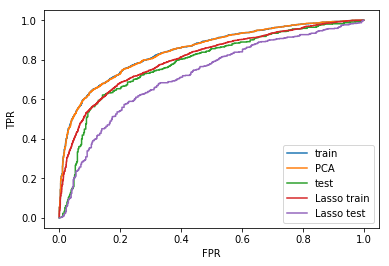

In [306]:
y_pred_train = clf_lin.predict_proba(X_train_imputed_scaled)[:, 1]
y_pred_test = clf_lin.predict_proba(X_test_imputed_scaled)[:, 1]
y_pred_train_p= clf_log_PCA.predict_proba(new_adv_df)[:, 1]
y_pred_train_l= clf_log_lasso.predict_proba(r2)[:, 1]
y_pred_test_l= clf_log_lasso.predict_proba(r2_test)[:, 1]

print('Train:')
calc_auc(Y, y_pred_train, 'train')
print('PCA:')
calc_auc(Y, y_pred_train_p, 'PCA')
print('Test:')
calc_auc(Y_test, y_pred_test, 'test')
print('Lasso train:')
calc_auc(Y, y_pred_train_l, 'Lasso train')
print('Lasso test:')
calc_auc(Y_test, y_pred_test_l, 'Lasso test')

plt.legend();

Train lasso:
ROC AUC: 0.8026


C:\Users\alexe\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


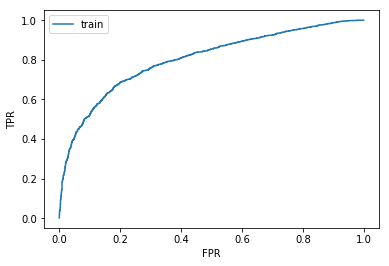

In [294]:
y_pred_train = clf_log_lasso.predict_proba(new_adv_df)[:, 1]

print('Train lasso:')
calc_auc(Y, y_pred_train, 'train')
plt.legend();

Train:
ROC AUC: 0.8427


0.842741795173783

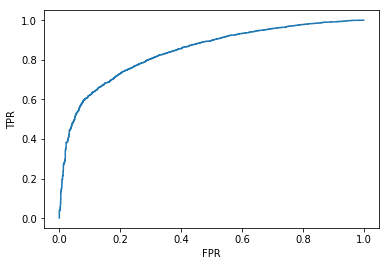

In [256]:
#Предсказания для конкурса
y_pred_train = clf_log.predict_proba(X_train_full_imputed_scaled)[:, 1]

print('Train:')
calc_auc(Y_full, y_pred_train, 'train')

In [257]:
#Делаем файл с предсказаниями
create_submit(clf_log, X_test_full_imputed_scaled, 'submit_log3.txt')

### Используем DecisionTreeClassifier

In [258]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_tree.fit(r, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Train:
ROC AUC: 0.9073
Test:
ROC AUC: 0.8002


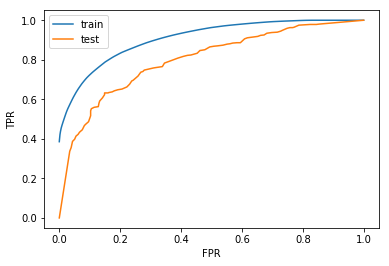

In [259]:
y_pred_train = clf_tree.predict_proba(r)[:, 1]
y_pred_test = clf_tree.predict_proba(r_test)[:, 1]

print('Train:')
calc_auc(Y, y_pred_train, 'train')
print('Test:')
calc_auc(Y_test, y_pred_test, 'test')
plt.legend();

In [260]:
clf_full_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
clf_full_tree.fit(mcc, Y_full)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Train:
ROC AUC: 0.9025


0.90249293096893513

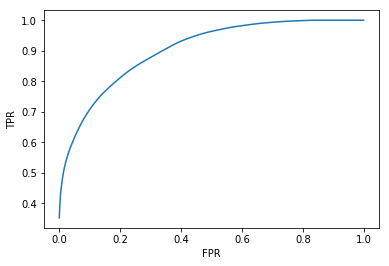

In [261]:
y_pred_train = clf_full_tree.predict_proba(mcc)[:, 1]

print('Train:')
calc_auc(Y_full, y_pred_train, 'train')

In [262]:
create_submit(clf_full_tree, mcc_test, 'submit_tree2.txt')

### Случайный лес

In [263]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=20, max_features=0.6, n_jobs=-1)

clf_rf.fit(X_train_imputed_scaled, Y)   

C:\Users\alexe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Train:
ROC AUC: 0.9126
Test:
ROC AUC: 0.8470


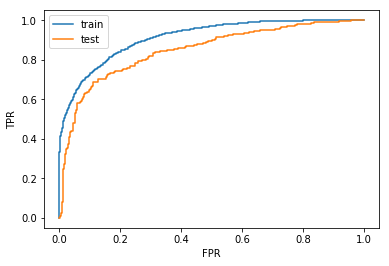

In [264]:
y_pred_train = clf_rf.predict_proba(X_train_imputed_scaled)[:, 1]
y_pred_test = clf_rf.predict_proba(X_test_imputed_scaled)[:, 1]

print('Train:')
calc_auc(Y, y_pred_train, 'train')
print('Test:')
calc_auc(Y_test, y_pred_test, 'test')
plt.legend();

In [265]:
clf_rf.fit(X_train_full_imputed_scaled, Y_full) 

C:\Users\alexe\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=0.6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Train:
ROC AUC: 0.9121


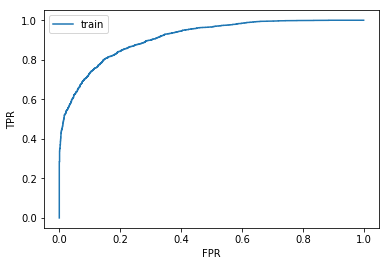

In [266]:
y_pred_train = clf_rf.predict_proba(X_train_full_imputed_scaled)[:, 1]

print('Train:')
calc_auc(Y_full, y_pred_train, 'train')
plt.legend();

In [267]:
create_submit(clf_rf, X_test_full_imputed_scaled, 'submit_rf4.txt')

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
3. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
4. **Обязательная часть**: на большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов
5. **Обязательная часть**: на фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в *sklearn.decomposition.pca.components_* после построения главных компонент)
6. **Обязательная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
8. **Дополнительная часть**: поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого необходимо использовать все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.
9. Задания принимаются в виде ноутбука с кодом/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    